### prognostic drifts

Figures showing drifts in variables over 40-day prognostic runs with various configurations (RF, NN, baseline)

In [1]:
import fsspec
import xarray as xr
import intake
from matplotlib import pyplot as plt, ticker, dates as mdates
import matplotlib
matplotlib.rcParams.update({'font.size': 10})
from dask.diagnostics import ProgressBar
import os
from vcm.catalog import catalog as CATALOG
from vcm.fv3.metadata import standardize_fv3_diagnostics
from vcm.calc import thermo
from typing import Mapping
from joblib import Parallel, delayed
from vcm.convenience import cast_to_datetime
import numpy as np

In [2]:
AREA = CATALOG['grid/c48'].to_dask()['area'].load()

In [3]:
GRAVITY = 9.81
LV = 2.5e6  # J/kg
CP =  1004.  # J/kg/K

def global_mean(ds, area, dims = ['x', 'y', 'tile']):
    return ((ds*area).sum(dim=dims))/(area.sum(dim=dims))

def mass_integrate(da, delp):
    return (da*delp/GRAVITY).sum(dim='z')

def global_mse(T, q, heights, area, delp):
    mse = CP*T + GRAVITY*heights + LV*q
    integrated_mse = mass_integrate(mse, delp)/1e9
    with ProgressBar():
        global_mse = global_mean(integrated_mse, area).load()
    return global_mse.assign_attrs({'long_name': 'global mean MSE', 'units': 'GJ/m**2'})
    

In [4]:
DELP = 'pressure_thickness_of_atmospheric_layer'
DELZ = 'vertical_thickness_of_atmospheric_layer'
PHIS = 'surface_geopotential'
T = 'air_temperature'
q = 'specific_humidity'

class Fv3gfsRun:
    
    def __init__(self, name, url, drift_vars):
        self.name: str = name
        self.url: str = url
        self.drift_vars: Mapping[str, str] = drift_vars
        self._diags: xr.Dataset = self._get_diags()
        self._state: xr.Dataset = self._get_state()
        self.global_mean_ts: xr.Dataset = self._global_mean_ts()
        
    def _global_mean_ts(self):
        if 'moist static energy' in self.drift_vars:
            self._diags['mse'] = self._mse()
        global_mean_ts = {}
        for plot_name, var in self.drift_vars.items():
            global_mean_ts[plot_name] = self._diags[var]
        ds = xr.Dataset(global_mean_ts).pipe(self._subset_time, hour=0).pipe(self._cast_time)
        return ds
    
    @staticmethod
    def _subset_time(ds, hour):
        return ds.sel(time=ds.time.loc[ds.time.dt.hour == hour])
    
    @staticmethod
    def _cast_time(ds):
        cast = np.vectorize(cast_to_datetime)
        return ds.assign_coords({'time': cast(ds.time)})
            
    def _mse(self):
        heights = thermo.height_at_midpoint(self._state[DELZ], self._state[PHIS], dim='z')
        return global_mse(self._state[T], self._state[q], heights, AREA, self._state[DELP])
    
    def _get_diags(self):
        diags_path = self._get_diags_path(self.url)
        print(f"Loading {self.name} diags at {diags_path}.")
        with fsspec.open(diags_path, 'rb') as f:
            ds = xr.open_dataset(f).load()
        return standardize_fv3_diagnostics(ds)
            
    def _get_state(self):
        state_path = os.path.join(self.url, 'state_after_timestep.zarr')
        print(f"Loading {self.name} state at {state_path}.")
        return standardize_fv3_diagnostics(intake.open_zarr(state_path, consolidated=True).to_dask())
    
    @staticmethod
    def _get_diags_path(run_url):
        prefix = 'gs://vcm-ml-archive/prognostic_run_diags'
        path_suffix = run_url.split('gs://')[1].replace("/", "-")
        return os.path.join(prefix, path_suffix, 'diags.nc')

In [5]:
DRIFT_TS_VARS = {
    '200hPa temperature': 'tmp200_spatial_mean_dycore_global',
    '850hPa temperature': 'tmp850_spatial_mean_dycore_global',
    'precipitable water': 'pwat_spatial_mean_dycore_global',
    'moist static energy': 'mse'
}

RUN_ARGS = [
    (
        'random forest',
        'gs://vcm-ml-experiments/2021-05-11-nudge-to-c3072-corrected-winds/rf/initial_conditions_runs/20160805.000000',
        DRIFT_TS_VARS
    ),
    (
        'NN tendencies + NN rad',
        "gs://vcm-ml-experiments/2021-05-11-nudge-to-c3072-corrected-winds/nn-ensemble-model/initial_conditions_runs_rf_rad/20160805.000000",
        DRIFT_TS_VARS
    ),
    (
        'baseline physics',
        'gs://vcm-ml-experiments/2021-04-13/baseline-physics-run-20160805-start-rad-step-1800s',
        DRIFT_TS_VARS
    )
]

# run_list = Parallel(n_jobs=len(RUN_ARGS), verbose=50, backend='multiprocessing')(delayed(Fv3gfsRun)(*args) for args in RUN_ARGS)
# run_list = [Fv3gfsRun(*args) for args in RUN_ARGS[slice(1)]]
run_list = [Fv3gfsRun(*args) for args in RUN_ARGS]

Loading random forest diags at gs://vcm-ml-archive/prognostic_run_diags/vcm-ml-experiments-2021-05-11-nudge-to-c3072-corrected-winds-rf-initial_conditions_runs-20160805.000000/diags.nc.
Loading random forest state at gs://vcm-ml-experiments/2021-05-11-nudge-to-c3072-corrected-winds/rf/initial_conditions_runs/20160805.000000/state_after_timestep.zarr.
[########################################] | 100% Completed |  3min 38.1s
Loading NN tendencies + NN rad diags at gs://vcm-ml-archive/prognostic_run_diags/vcm-ml-experiments-2021-05-11-nudge-to-c3072-corrected-winds-nn-ensemble-model-initial_conditions_runs_rf_rad-20160805.000000/diags.nc.
Loading NN tendencies + NN rad state at gs://vcm-ml-experiments/2021-05-11-nudge-to-c3072-corrected-winds/nn-ensemble-model/initial_conditions_runs_rf_rad/20160805.000000/state_after_timestep.zarr.
[########################################] | 100% Completed |  3min 36.3s
Loading baseline physics diags at gs://vcm-ml-archive/prognostic_run_diags/vcm-ml-ex

In [8]:
def plot_global_ts(runlist, varnames):
    fig, axes = plt.subplots(2, 2)
    for i, (ax, var) in enumerate(zip(axes.flatten(), varnames)):
        for run in runlist:
             ax.plot(run.global_mean_ts.time, run.global_mean_ts[var], label=run.name)
        if i == 0:
            ax.legend()
        ax.set_xlim([run.global_mean_ts.time[0], run.global_mean_ts.time[-1]])
        ax.set_xticklabels(ax.get_xticks(), rotation = 45)
        ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.SA))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        ax.grid(axis='y')
        ax.set_ylabel(run.global_mean_ts[var].attrs.get('units'))
        ax.set_title(var)
        if var == 'moist static energy':
            ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.3f}"))
        else:
            ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.1f}"))
    fig.set_size_inches([10, 8])
    fig.set_dpi(150)
    fig.tight_layout()

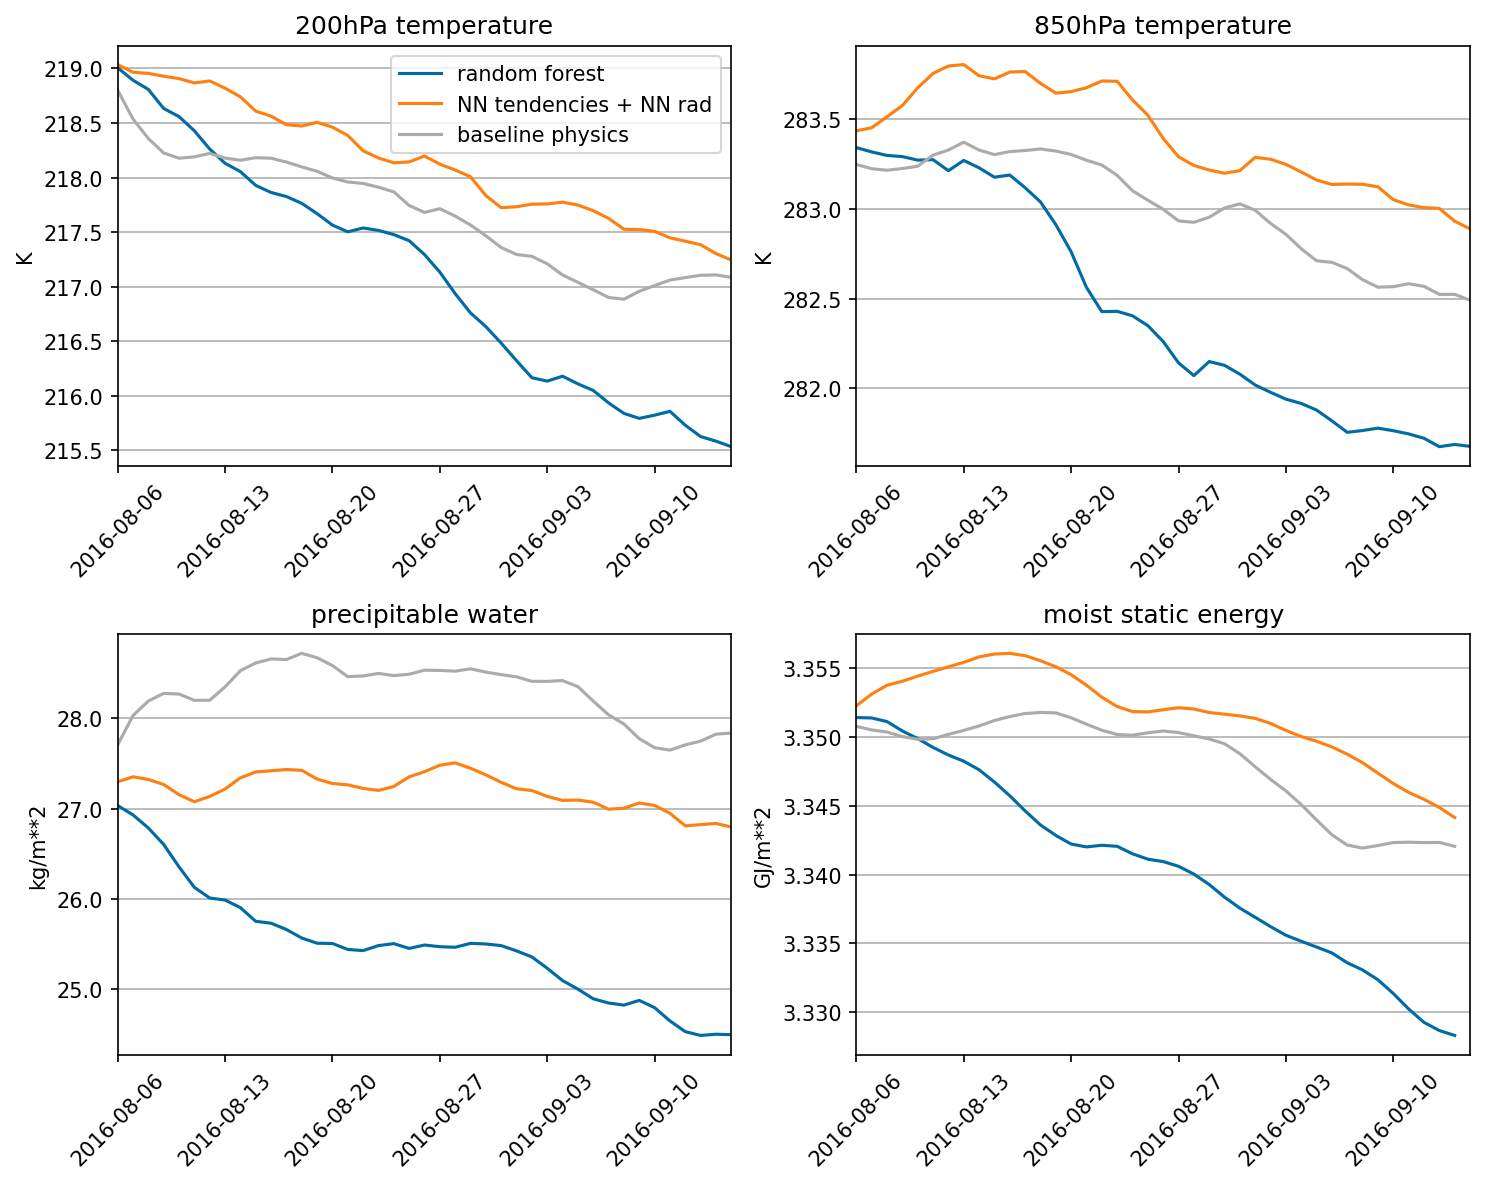

In [10]:
plot_global_ts(run_list, DRIFT_TS_VARS)